# Example Surface Area Finding Using a Sphere

## Load in Libraries

In [1]:
from scipy.spatial import Delaunay
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpltPath
%matplotlib widget
import pandas as pd
import cv2
import math

In [2]:
data = pd.read_csv("../Data/ExampleBoundaryTable.csv")
data.head()

,x,y
0,2125,126
1,2124,127
2,2123,127
3,2122,127
4,2121,127


# Load in Male Right Arm Mesh Data

In [3]:
imported_data =\
    np.load("../Data/male right arm mesh data.npz")
mesh_verticies = imported_data["mesh_verticies"]
mesh_faces = imported_data["mesh_faces"]

# Load in uv data
uv_array = imported_data["uv_array"]

# import the face data
face_data = pd.DataFrame(imported_data["face_data"],
                              columns=["vertex", "uv", "normal"])

# Function to Find UV vertex indicies

In [4]:
def find_uv_index(centroid_x: float, centroid_y: float,
                  image_x_size: int, image_y_size: int) -> int:
    '''
    Converts location drawing pixel value to UV value

    Takes the location drawing's centroid pixel location and converts it
    to a 3D vertex on the mesh by finding the closest UV value to the pixel

    Parameters
    ----------
    centroid_x: float
        The x pixel value of a location centroid
    centroid_y: float
        The y pixel value of a location centroid
    image_x_size: int
        The x dimension of the location drawing image in pixels
    image_y_size: int
        The y dimension of the location drawing image in pixels

    Returns
    -------
    nearest_uv_id: int
        The row number of the closest uv to the 2D centroid
    '''
    normalized_x = centroid_x / image_x_size
    normalized_y = centroid_y / image_y_size
    uv_location = np.array([normalized_x, 1 - normalized_y])
    distances_to_uvs = np.linalg.norm(uv_array - uv_location, axis=1)
    nearest_uv_id = distances_to_uvs.argsort()[0]
    return nearest_uv_id

In [5]:
# Find the image dimensions
img = cv2.imread('../Media/right arm.png', 1)
image_x_size = img.shape[1]
image_y_size = img.shape[0]
print(image_x_size)

1942


# Make a list of UV Vertex Indicies

In [6]:
boundary_uv_array = []
for index, row in data.iterrows():
    uv_index = find_uv_index(row["y"], row["x"], image_x_size, image_y_size)
    boundary_uv_array.append(uv_index)

# Check the Original Path vs UV Path

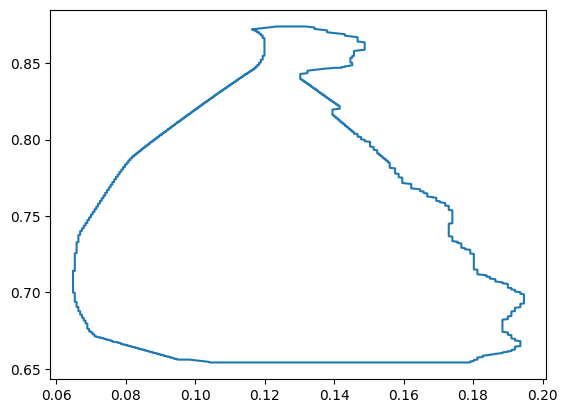

In [7]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(data["y"] / image_x_size, 1 - data["x"] / image_y_size)

## Clean up Duplicate UV Indicies

In [8]:
print(len(boundary_uv_array))

3441


In [9]:
cleaned_boundary_uv_array = []
[cleaned_boundary_uv_array.append(x) for x in boundary_uv_array if x not in cleaned_boundary_uv_array]

print(len(cleaned_boundary_uv_array))

584


That is a reduction to 17% the number of verticies in the path

## Check Original Boundary

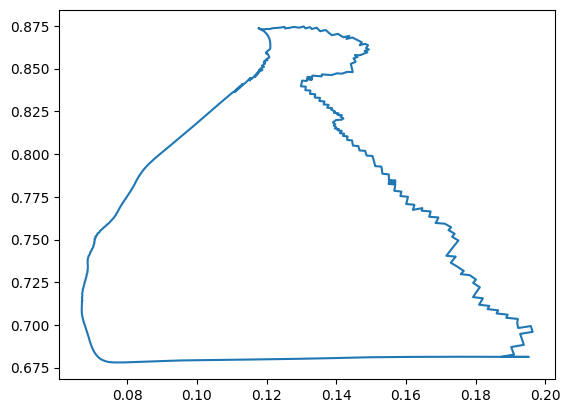

In [10]:
path = uv_array[boundary_uv_array]
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(path[:, 0], path[:, 1])

## Check Cleaned Boundary

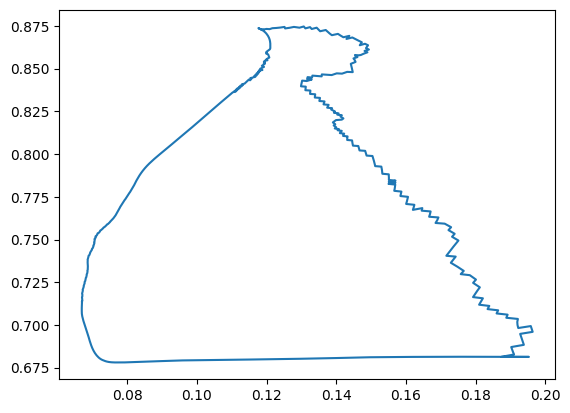

In [11]:
path = uv_array[cleaned_boundary_uv_array]
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(path[:, 0], path[:, 1])

# Find all UV Points in the UV Boundary

In [12]:
boundary = mpltPath.Path(path)
inside_boundary = boundary.contains_points(uv_array)

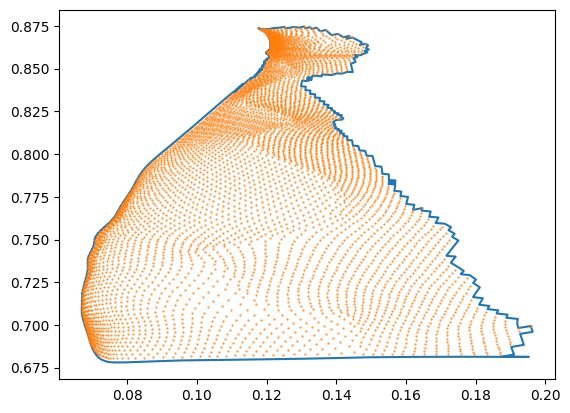

In [13]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(path[:, 0], path[:, 1])
ax.plot(uv_array[inside_boundary, 0], uv_array[inside_boundary, 1], '.',
        markersize=1)

## Drawn Location on Full UV Map

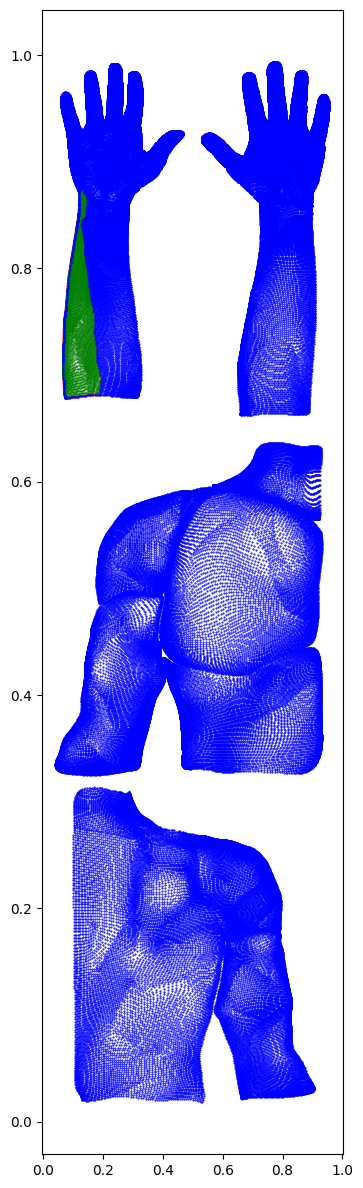

In [14]:
fig = plt.figure(figsize=(image_x_size/500, image_y_size/500))
ax = fig.add_subplot()
ax.plot(path[:, 0], path[:, 1], 'r-', markersize=2)
ax.plot(uv_array[inside_boundary, 0], uv_array[inside_boundary, 1], 'g.', markersize=1)
ax.plot(uv_array[np.invert(inside_boundary), 0],
           uv_array[np.invert(inside_boundary), 1], 'b.', markersize=1)

# Triangulate the found Mesh

In [15]:
location_uvs = np.array(uv_array[cleaned_boundary_uv_array])
location_uvs = np.concatenate((location_uvs, uv_array[inside_boundary]))
triangulated_uvs = Delaunay(location_uvs)
print(len(location_uvs))

6630


## Visualize the Triangulation

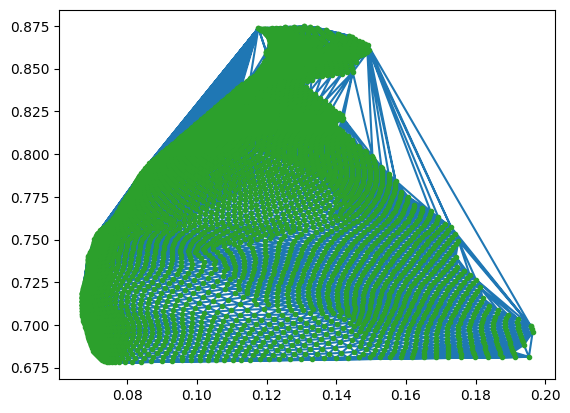

In [16]:
fig = plt.figure()
plt.triplot(location_uvs[:,0], location_uvs[:,1], triangulated_uvs.simplices)
plt.plot(location_uvs[:,0], location_uvs[:,1], '.')

# Eliminate the Triangles on the Outside of the Drawing

In [17]:
highest_boundary_index = len(cleaned_boundary_uv_array)
triangles = np.array(triangulated_uvs.simplices)
reduced_triangles = []
for row in triangles:
    if np.all(row >= highest_boundary_index):
        reduced_triangles.append(row)
print(len(triangles))
print(len(reduced_triangles))
reduced_triangles = np.array(reduced_triangles)

13142
11363


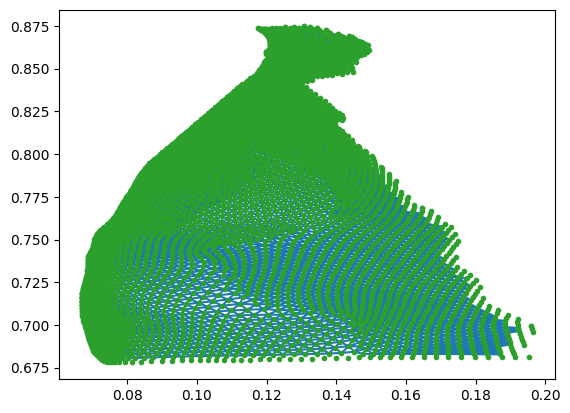

In [18]:
fig = plt.figure()
plt.triplot(location_uvs[:,0], location_uvs[:,1], reduced_triangles)
plt.plot(location_uvs[:,0], location_uvs[:,1], '.')

# Get the 3D verticies

## Boundary Verticies Indicies

In [19]:
boundary_vertex_ids = []
for index in cleaned_boundary_uv_array:
    boundary_vertex_ids.append(int(face_data.loc[face_data["uv"] == index]["vertex"].values[0]))

## Inner Verticies Indicies

In [20]:
# get indicies of true values in inside_boundary
inside_boundary_ids = [i for i, x in enumerate(inside_boundary) if x]
inner_vertex_ids = []
for index in inside_boundary_ids:
    inner_vertex_ids.append(int(face_data.loc[face_data["uv"] == index]["vertex"].values[0]))

In [21]:
len(inner_vertex_ids)

6046

## Get the Actual Verticies from the Mesh

In [22]:
location_surface = np.array(mesh_verticies[boundary_vertex_ids])
location_surface = np.concatenate((location_surface, mesh_verticies[inner_vertex_ids]))

In [23]:
location_surface.shape

(6630, 3)

# Show Mesh

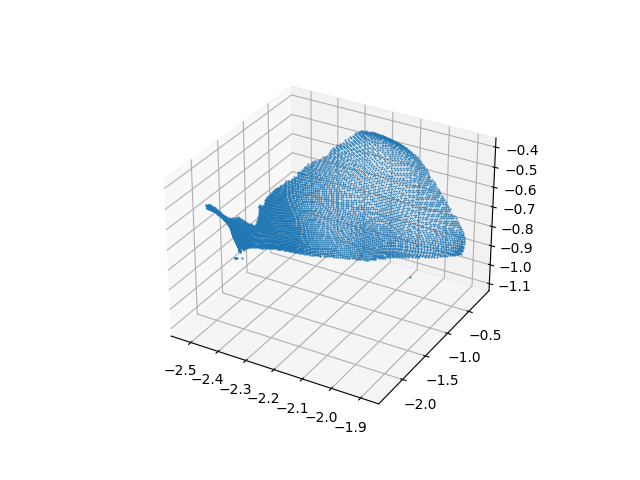

In [24]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(location_surface[:, 0], location_surface[:, 1],
        location_surface[:, 2], '.', markersize=1)



# Show Triangles on Mesh

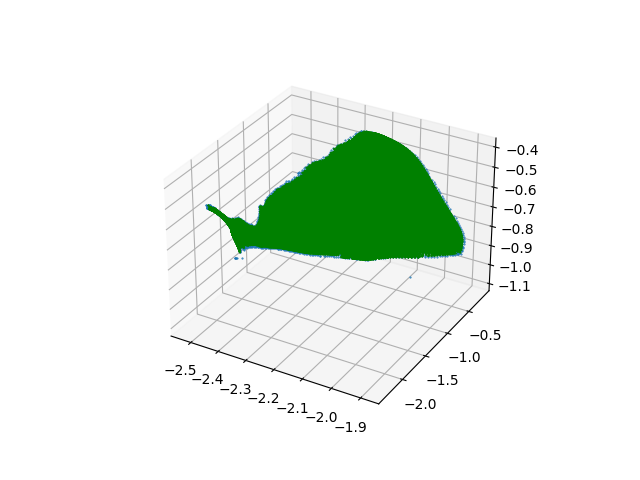

In [25]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(location_surface[:, 0], location_surface[:, 1],
        location_surface[:, 2], '.', markersize=1)

for tri in reduced_triangles:
        ax.plot(location_surface[tri, 0], location_surface[tri, 1],
                location_surface[tri, 2], 'g-', markersize=1)

# Find the Surface Area

## Heron's Formula
Given any triangle with sides of length a, b, and c:
The area is $$A = \sqrt{s(s-a)(s-b)(s-c)}$$ where $$s = \frac{a+b+c}{2}$$

In [26]:
def heron_area(p1, p2, p3):
    a = np.linalg.norm(p1 - p2)
    b = np.linalg.norm(p2 - p3)
    c = np.linalg.norm(p1 - p3)
    s = (a + b + c) / 2
    return math.sqrt(s * (s - a) * (s - b) * (s - c))

In [27]:
area = 0
for tri in reduced_triangles:
    p1 = location_surface[tri[0]]
    p2 = location_surface[tri[1]]
    p3 = location_surface[tri[2]]
    area += heron_area(p1, p2, p3)

print(f"The area of the drawn location is {area} units")

The area of the drawn location is 0.8153308243736922 units
